In [1]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.set_logical_device_configuration(physical_devices[0], 
   [tf.config.LogicalDeviceConfiguration(memory_limit=5120)])

2024-12-05 12:58:52.654323: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733378332.668610  390093 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733378332.672903  390093 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-05 12:58:52.688229: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from datasets import load_dataset

data_files = {
    "indosum/test.04.jsonl",
}

# Muat dataset
dataset = load_dataset("json", data_files=data_files)
print(dataset)

/home/rakhargo/miniconda3/envs/cudaTF/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['category', 'gold_labels', 'id', 'paragraphs', 'source', 'source_url', 'summary'],
        num_rows: 3752
    })
})


In [3]:
train_data = dataset['train']
print(train_data[0])

{'category': 'tajuk utama', 'gold_labels': [[True], [False, False, False], [False], [True], [True], [False], [False], [False], [False, False], [False], [False, False, False], [False, False], [False]], 'id': '1504151262-wiranto-yakin-uang-bos-first-travel-bisa-ditemukan', 'paragraphs': [[['Jakarta', ',', 'CNN', 'Indonesia', '-', '-', 'Menteri', 'Koordinator', 'bidang', 'Politik', ',', 'Hukum', ',', 'dan', 'Keamanan', '(', 'Menko', 'Polhukam', ')', 'Wiranto', 'yakin', 'uang', 'jemaah', 'yang', 'dikumpulkan', 'bos', 'First', 'Travel', ',', 'Andika', 'Surachman', 'dan', 'Anniesa', 'Hasibuan', ',', 'bisa', 'ditemukan', '.']], [['"', 'Uang', 'itu', 'kan', 'cuma', 'pindah', 'tempat', ',', 'enggak', 'ada', 'uang', 'menguap', ',', 'itu', 'enggak', 'ada', '.'], ['Enggak', 'ada', 'tiba-tiba', 'uang', 'hilang', 'menguap', ',', 'mesti', 'pindah', 'tempat', '.'], ['Kita', 'cari', 'itu', ',', '"', 'ujar', 'Wiranto', 'di', 'Hotel', 'Arya', 'Duta', ',', 'Jakarta', ',', 'Rabu', '\xa0', '(', '30', '/', '

In [4]:
def join_data(dataset):
    documents = []
    summaries = []
    for item in dataset:
        document = [" ".join(sent) for para in item["paragraphs"] for sent in para]
        summary = " ".join([" ".join(sent) for sent in item["summary"]])
        
        documents.append(document)
        summaries.append(summary)
    
    return documents, summaries

# Memproses data
train_docs, train_summaries = join_data(train_data)

In [5]:
print(train_docs[0])
print(train_summaries[0])
len(train_docs)

['Jakarta , CNN Indonesia - - Menteri Koordinator bidang Politik , Hukum , dan Keamanan ( Menko Polhukam ) Wiranto yakin uang jemaah yang dikumpulkan bos First Travel , Andika Surachman dan Anniesa Hasibuan , bisa ditemukan .', '" Uang itu kan cuma pindah tempat , enggak ada uang menguap , itu enggak ada .', 'Enggak ada tiba-tiba uang hilang menguap , mesti pindah tempat .', 'Kita cari itu , " ujar Wiranto di Hotel Arya Duta , Jakarta , Rabu \xa0 ( 30 / 8 ) .', 'Pernyataan Wiranto itu merujuk tipisnya jumlah dana yang berada di rekening bos First Travel , sementara jemaah yang dana keberangkatan umrahnya ditilap mencapai sekitar Rp 848 miliar .', 'Wiranto mengatakan , uang yang diambil bos First Travel tersebut penting untuk ditemukan karena harus dikembalikan kepada para jemaah yang telah ditipu .', 'Mantan Panglima ABRI itu juga menyampaikan , First Travel tetap menjadi pihak yang harus bertanggung jawab untuk mengembalikan uang para jemaah .', '" Yang gantinya siapa yang merugikan r

3752

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

start_token = '<start>'
end_token = '<end>'

train_summaries = [start_token + ' ' + summary + ' ' + end_token for summary in train_summaries]

input_tokenizer = Tokenizer()
output_tokenizer = Tokenizer()
input_tokenizer.fit_on_texts(train_docs)
output_tokenizer.fit_on_texts(train_summaries)

input_vocab_size = len(input_tokenizer.word_index) + 1
output_vocab_size = len(output_tokenizer.word_index) + 1

# Mengubah teks menjadi sequence
X = input_tokenizer.texts_to_sequences(train_docs)
y = output_tokenizer.texts_to_sequences(train_summaries)

max_input_length = max(len(seq) for seq in X)
max_output_length = max(len(seq) for seq in y)

X_train = pad_sequences(X, maxlen=max_input_length, padding='post')
y_train = pad_sequences(y, maxlen=max_output_length, padding='post')

print(X_train.shape)  
print(y_train.shape)

print(input_vocab_size)
print(output_vocab_size)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Prepare the training data for the decoder (Shift the target sequences)
y_train_decoder_input = y_train[:, :-1]  # Remove the last token
y_train_decoder_output = y_train[:, 1:]  # Shift the sequence by 1 for teacher forcing

(3752, 71)
(3752, 93)
67435
22973


In [7]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model

class LookAheadMaskLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(LookAheadMaskLayer, self).__init__(**kwargs)
    
    def call(self, inputs):
        size = tf.shape(inputs)[1]
        mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
        return mask

class PositionalEncoding(layers.Layer):
    def __init__(self, max_length, d_model):
        super(PositionalEncoding, self).__init__()
        self.max_length = max_length
        self.d_model = d_model
        self.position_encoding = self._create_positional_encoding()
    
    def _create_positional_encoding(self):
        position = np.arange(self.max_length)[:, np.newaxis]
        div_term = np.exp(np.arange(0, self.d_model, 2) * -(np.log(10000.0) / self.d_model))
        
        pe = np.zeros((self.max_length, self.d_model))
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        
        return tf.constant(pe[np.newaxis, ...], dtype=tf.float32)
    
    def call(self, inputs):
        return inputs + self.position_encoding[:, :tf.shape(inputs)[1], :]

def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        layers.Dense(dff, activation='relu'),
        layers.Dense(d_model)
    ])

class TransformerEncoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(TransformerEncoderLayer, self).__init__()
        
        self.mha = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
    
    def call(self, x, training, mask=None):
        attn_output = self.mha(x, x, attention_mask=mask)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2

class TransformerDecoderLayer(layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(TransformerDecoderLayer, self).__init__()
        
        self.mha1 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.mha2 = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = point_wise_feed_forward_network(d_model, dff)
        
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)
        self.dropout3 = layers.Dropout(rate)
    
    def call(self, x, enc_output, training, look_ahead_mask=None, padding_mask=None):
        # Self-attention with look-ahead mask
        attn1 = self.mha1(x, x, attention_mask=look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(x + attn1)
        
        # Cross-attention with encoder output
        attn2 = self.mha2(out1, enc_output, attention_mask=padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(out1 + attn2)
        
        # Feed-forward network
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(out2 + ffn_output)
        
        return out3

def transformer_model(
    input_vocab_size, 
    target_vocab_size, 
    pe_max_length, 
    d_model=128, 
    num_heads=8, 
    num_layers=4, 
    dff=512, 
    dropout_rate=0.1
):
    # Inputs
    inputs = layers.Input(shape=(None,))
    targets = layers.Input(shape=(None,))
    
    # Embedding layers
    embedding = layers.Embedding(input_vocab_size, d_model)
    pos_encoding = PositionalEncoding(pe_max_length, d_model)
    
    # Encoder
    encoder_input = embedding(inputs)
    encoder_input = pos_encoding(encoder_input)
    
    # Multiple encoder layers
    encoder_output = encoder_input
    for _ in range(num_layers):
        encoder_output = TransformerEncoderLayer(
            d_model=d_model, 
            num_heads=num_heads, 
            dff=dff,
            rate=dropout_rate
        )(encoder_output, training=True)
    
    # Decoder
    decoder_input = embedding(targets)
    decoder_input = pos_encoding(decoder_input)
    
    # Look-ahead mask layer
    look_ahead_mask_layer = LookAheadMaskLayer()
    look_ahead_mask = look_ahead_mask_layer(targets)
    
    # Multiple decoder layers
    decoder_output = decoder_input
    for _ in range(num_layers):
        decoder_output = TransformerDecoderLayer(
            d_model=d_model, 
            num_heads=num_heads, 
            dff=dff,
            rate=dropout_rate
        )(decoder_output, encoder_output, training=True, look_ahead_mask=look_ahead_mask)
    
    # Final output layer
    outputs = layers.Dense(target_vocab_size, activation='softmax')(decoder_output)
    
    model = Model(inputs=[inputs, targets], outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Contoh penggunaan
model = transformer_model(
    input_vocab_size=input_vocab_size, 
    target_vocab_size=output_vocab_size, 
    pe_max_length=max(max_input_length, max_output_length),
    d_model=128, 
    num_heads=4, 
    num_layers=4, 
    dff=512, 
    dropout_rate=0.1
)
model.summary()

I0000 00:00:1733378338.066158  390093 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5120 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 128) │  8,631,680 │ input_layer[0][0… │
│ (Embedding)         │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, None, 128) │          0 │ embedding[0][0],  │
│ (PositionalEncodin… │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 128) │    396,032 │ positional_encod… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 128) │    396,032 │ transformer_enco… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 128) │    396,032 │ transformer_enco… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 128) │    396,032 │ transformer_enco… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ look_ahead_mask_la… │ (None, None)      │          0 │ input_layer_1[0]… │
│ (LookAheadMaskLaye… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 128) │    660,096 │ positional_encod… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
│                     │                   │            │ look_ahead_mask_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 128) │    660,096 │ transformer_deco… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
│                     │                   │            │ look_ahead_mask_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 128) │    660,096 │ transformer_deco… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
│                     │                   │            │ look_ahead_mask_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 128) │    660,096 │ transformer_deco… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
│                     │                   │            │ look_ahead_mask_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, None,      │  2,963,517 │ transformer_deco… │
│                     │ 22973)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,819,709 (60.35 MB)

 Trainable params: 15,819,709 (60.35 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the model
history = model.fit(
    [X_train, y_train_decoder_input], y_train_decoder_output,
    epochs=25, validation_split=0.2
)

Epoch 1/25


I0000 00:00:1733378354.603535  390186 service.cc:148] XLA service 0x7f33ec018530 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733378354.603600  390186 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-12-05 12:59:15.166551: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733378357.149772  390186 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-05 12:59:20.822268: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_303', 120 bytes spill stores, 120 bytes spill loads

2024-12-05 12:59:20.839987: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_303

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.3214 - loss: 8.0203

W0000 00:00:1733378423.489880  390185 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733378426.415374  390184 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-12-05 13:00:27.633811: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 112 bytes spill stores, 112 bytes spill loads

2024-12-05 13:00:27.658570: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 164 bytes spill stores, 172 bytes spill loads

2024-12-05 13:00:27.912558: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local mem

75/75 ━━━━━━━━━━━━━━━━━━━━ 97s 291ms/step - accuracy: 0.3216 - loss: 8.0042 - val_accuracy: 0.3572 - val_loss: 5.3917
Epoch 2/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 99ms/step - accuracy: 0.3615 - loss: 5.2761 - val_accuracy: 0.3690 - val_loss: 5.3401
Epoch 3/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 101ms/step - accuracy: 0.3701 - loss: 5.1699 - val_accuracy: 0.3734 - val_loss: 5.0943
Epoch 4/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.3725 - loss: 4.9041 - val_accuracy: 0.3799 - val_loss: 4.8299
Epoch 5/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.3809 - loss: 4.6081 - val_accuracy: 0.3824 - val_loss: 4.6464
Epoch 6/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.3878 - loss: 4.3391 - val_accuracy: 0.4108 - val_loss: 4.1992
Epoch 7/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 97ms/step - accuracy: 0.4184 - loss: 3.9486 - val_accuracy: 0.4458 - val_loss: 3.7630
Epoch 8/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.4493 - loss: 3.5656 - val_accuracy: 0.4919 - val_loss:

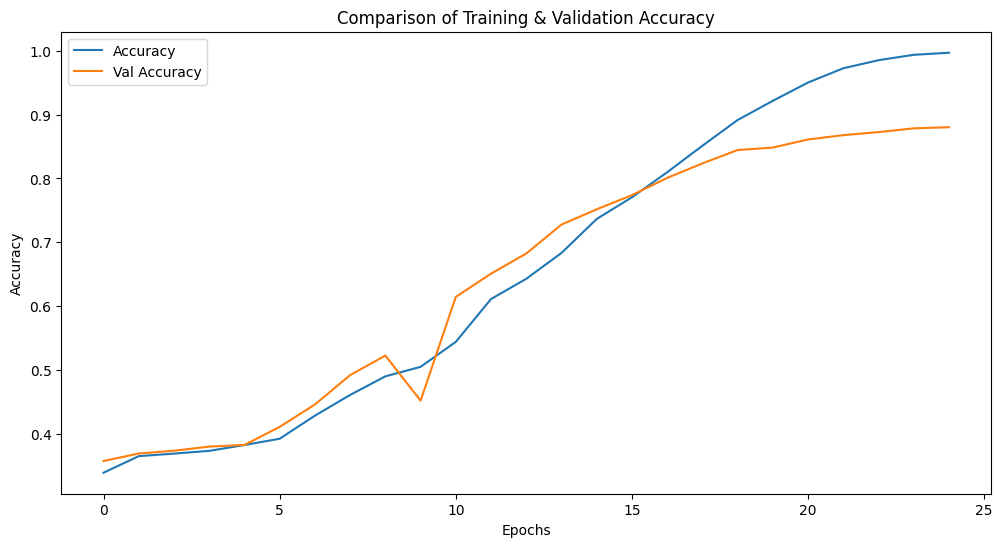

In [9]:
import matplotlib.pyplot as plt

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(accuracy, label='Accuracy')
plt.plot(val_accuracy, label='Val Accuracy')

plt.title('Comparison of Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

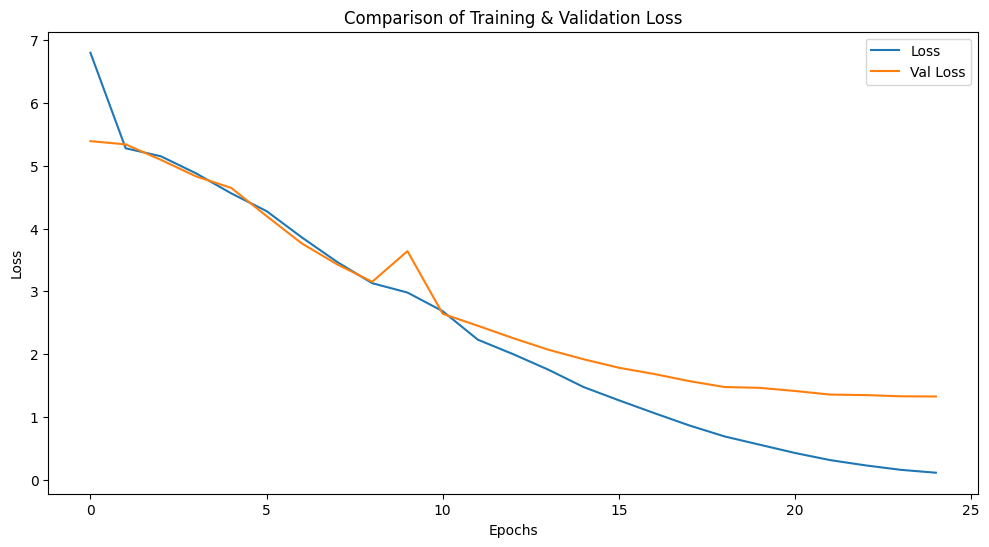

In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))
plt.plot(loss, label='Loss')
plt.plot(val_loss, label='Val Loss')

plt.title('Comparison of Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
model.save('best_model.keras')

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

# Fungsi untuk mengonversi sequence ke teks
def sequence_to_text(sequence, tokenizer):
    reverse_word_map = {v: k for k, v in tokenizer.word_index.items()}
    return ' '.join([reverse_word_map.get(idx, '') for idx in sequence if idx != 0])

# Variabel untuk menyimpan skor BLEU
bleu_scores = []

# Prediksi pada data test
for i in range(len(X_test)):
    # Data input
    input_test = X_test[i:i+1]
    reference_test = y_test[i]

    # Awal input decoder (start token)
    decoder_input = np.zeros((1, 1))  # Anggap 0 adalah token <start>
    
    # Simpan prediksi token
    predicted_sequence = []
    
    for _ in range(max_output_length):  # Batasi panjang maksimum output
        # Prediksi satu langkah
        prediction = model.predict([input_test, decoder_input], verbose=0)
        predicted_id = np.argmax(prediction[:, -1, :], axis=-1)  # Token terakhir
        predicted_sequence.append(predicted_id[0])
        
        # Berhenti jika menemukan token <end>
        if predicted_id[0] == 0:  # Ganti '0' dengan token akhir sebenarnya
            break
        
        # Tambahkan prediksi ke decoder input
        decoder_input = np.concatenate([decoder_input, [[predicted_id[0]]]], axis=1)
    
    # Konversi sequence ke teks
    real_text = sequence_to_text(X_test[i], input_tokenizer)
    reference_summary = sequence_to_text(reference_test, output_tokenizer)
    predicted_summary = sequence_to_text(predicted_sequence, output_tokenizer)
    
    # Hitung BLEU Score
    reference_tokens = reference_summary.split()
    predicted_tokens = predicted_summary.split()
    bleu_score = sentence_bleu([reference_tokens], predicted_tokens)
    bleu_scores.append(bleu_score)
    
    # Tampilkan data 3 pertama
    if i < 5:
        print(f"Data {i+1}")
        print(f"Real Text: {real_text}")
        print(f"Reference Summary: {reference_summary}")
        print(f"Predicted Summary: {predicted_summary}")
        print(f"BLEU Score: {bleu_score}")
        print()

# Hitung rata-rata BLEU Score
avg_bleu = sum(bleu_scores) / len(bleu_scores)
print("Average BLEU Score:", avg_bleu)


2024-12-05 13:06:55.190428: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_98', 112 bytes spill stores, 112 bytes spill loads

2024-12-05 13:06:55.288063: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_89', 24 bytes spill stores, 24 bytes spill loads

2024-12-05 13:06:55.326577: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_90', 64 bytes spill stores, 64 bytes spill loads

2024-12-05 13:06:55.532984: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_98', 120 bytes spill stores, 120 bytes spill loads

2024-12-05 13:06:55.676563: I external/local_xla/xla/stream_exec

Data 1
Real Text: jakarta , cnn indonesia - - penyelidik amerika serikat dilaporkan sudah bertemu dengan christopher steele , mantan mata-mata inggris yang membocorkan isu hubungan antara tim kampanye donald trump dan rusia pada masa pemilihan umum 2016 . informasi mengenai pertemuan ini dihimpun oleh cnn dari dua sumber yang dekat dengan penyelidikan . cnn melaporkan , pertemuan antara penyelidik dari dewan khusus pimpinan mantan kepala fbi , robert mueller , bertemu dengan steele pada musim panas lalu . " cnn mengetahui bahwa fbi dan komunitas intelijen as menanggapi bocoran steele lebih serius ketimbang badan-badan lain yang mengetahuinya , " demikian bunyi laporan cnn , kamis ( 5 / 10 ) . nama steele menjadi perhatian publik setelah merilis berkas penelitian politik setebal 35 halaman yang menguak kemungkinan intervensi rusia untuk memenangkan trump dalam pemilu lalu . berkas itu mencakup klaim bahwa rusia memiliki video prostitusi yang direkam saat trump mengunjungi salah satu hot